In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

In [2]:
issue_date = dt.date(2022,4,25)
maturity_date = dt.date(2023,10,25) 
bussiness_days = np.busday_count(issue_date, maturity_date) + 1 

In [3]:
earlyredemption_dates = [dt.date(2023,4,25), dt.date(2023,7,25)]

In [4]:
coupon_dates = [dt.date(2022,8,2),dt.date(2022,11,2),dt.date(2023,2,2),dt.date(2023,5,2),dt.date(2023,8,2),dt.date(2023,11,2)]

### finding exchange rate on a future date using GBM

In [5]:
ticker = ['HKD=X']

start_date = dt.date(2019,4,25)
end_date = dt.date(2022,4,25)

df2 = yf.download(ticker,start_date,end_date,progress=False)['Adj Close']
df2=df2.fillna(method='ffill')

df2

Date
2019-04-25    7.84270
2019-04-26    7.84360
2019-04-29    7.84284
2019-04-30    7.84410
2019-05-01    7.84550
               ...   
2022-04-19    7.84150
2022-04-20    7.84190
2022-04-21    7.84390
2022-04-22    7.84460
2022-04-25    7.84629
Name: Adj Close, Length: 782, dtype: float64

In [6]:
np.std(df2)
date_index = pd.date_range(issue_date, maturity_date, freq='B')
r = np.array(0.0233)

In [7]:
np.std(df2)
X2a = []
for i in range(393):
    X2=np.random.normal(0,1)
    
    X2a.append(X2)
    
def gbm2 (X2a,e0,T,sig,r,n=bussiness_days):
    
    dt = T/n
    E = [e0]
    for i in range(1,n):
        E.append(E[i-1]*np.exp((r-0.5*sig**2)*dt + sig*np.sqrt(dt)*X2a[i-1]))
    return E 

date_ind = pd.date_range(issue_date, maturity_date, freq='B')
df4 = pd.DataFrame(index=date_index)

for i,key in enumerate(ticker):
    df4 = gbm2(e0=df2[-1],T=18/12,sig=0.032,r=r,n=bussiness_days,X2a=X2a)
        
    print(df4[-1:])

[8.542237138891073]


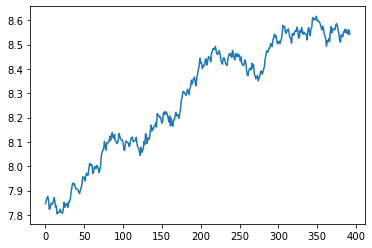

In [8]:
plt.plot(df4)

 ###  estimation  from historical data  

In [10]:
strike = np.array((0.7,0.7,0.7))
call_trigger = np.array((1.0,1.0,1.0))

conversion_ratio ={'9988.HK' : 7454.60, 'GOOGL' : 29.85, 'AMZN' : 24.74}

In [11]:
tickers = ['9988.HK','GOOGL','AMZN']
start_date = dt.date(2020,4,25)
end_date = dt.date(2022,4,25)

In [12]:
df = yf.download(tickers,start_date,end_date,progress=False)['Adj Close']
df=df.fillna(method='ffill')

In [13]:
df

,9988.HK,AMZN,GOOGL
Date,,,
2020-04-27,200.600006,2376.000000,1270.859985
2020-04-28,199.000000,2314.080078,1232.589966
2020-04-29,197.000000,2372.709961,1342.180054
2020-04-30,197.000000,2474.000000,1346.699951
2020-05-01,197.000000,2286.040039,1317.319946
...,...,...,...
2022-04-19,91.500000,3162.310059,2600.179932
2022-04-20,90.699997,3079.959961,2560.800049
2022-04-21,87.900002,2965.919922,2496.290039


In [14]:
df['9988.HK'] = df['9988.HK'] / df4[-1:]
df

,9988.HK,AMZN,GOOGL
Date,,,
2020-04-27,23.483310,2376.000000,1270.859985
2020-04-28,23.296005,2314.080078,1232.589966
2020-04-29,23.061874,2372.709961,1342.180054
2020-04-30,23.061874,2474.000000,1346.699951
2020-05-01,23.061874,2286.040039,1317.319946
...,...,...,...
2022-04-19,10.711480,3162.310059,2600.179932
2022-04-20,10.617827,3079.959961,2560.800049
2022-04-21,10.290045,2965.919922,2496.290039


###  treasury rates as on 04/25/2022 (interpolation between 1 year and 2 years) 

In [15]:
r = np.array(0.0233)
sigma = df.pct_change().cov() * 252

### finding dividend yields on our underlying assets

In [16]:
d = np.zeros(3)
for i,key in enumerate(tickers):
    d[i] = yf.Ticker(key).info['trailingAnnualDividendYield']

### using cholesky decomposition we can get correlation and then apply geomatric brownian motion 

In [17]:
chol = np.matrix(np.linalg.cholesky(sigma))

In [18]:
def correlation_r(a=3,b=bussiness_days,c=chol):
        Z = np.zeros((a,b))
        for i in range(0,a):
            Z[i] = np.random.normal(0,1,b)
        X = np.array(c * Z)
        return(X)

In [19]:
def gbm(s0,T,sigma,r,div,n=bussiness_days,X=np.random.normal(0,1,bussiness_days)):
        dt = T/n
        S = [s0]
        for i in range(1,n):
            S.append(S[i-1]*np.exp((r-div-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*X[i-1]))
        return S

### after this we simulate payoff using the conditions given in products (more explaination in project report)

In [20]:
N = 10**3
prices = []
for j in range(N):
    date_index = pd.date_range(issue_date, maturity_date, freq='B')
    df3 = pd.DataFrame(index=date_index)
    X = correlation_r()
    for i,key in enumerate(tickers):
        df3[key] = gbm(s0=df[key][-1],T=18/12,sigma=sigma.iloc[i,i],r=r,div=d[i],n=bussiness_days,X=X[i])
    indexed_df = df3/df3.iloc[0]
    condition1 = []
    for i in range(len(earlyredemption_dates)):
            condition1.append((indexed_df.loc[str(earlyredemption_dates[i])] > call_trigger).astype(int).prod())
    condition2 = 1
    for i in range(len(indexed_df[-1:])):
        if indexed_df.iloc[-1][i] < strike[i]:
            condition2 = 0
            break
    investment = 50000
    coupon_rate = 0.01342
    discount_factor = np.exp(-r * 18/12) 
    worst_performance = indexed_df.iloc[-1].idxmin()
    condition3 = 1
    payments = pd.DataFrame(np.zeros(len(coupon_dates)),index=coupon_dates, columns=['cash'])
    for i in range(3):
        payments.iloc[i] = investment * coupon_rate
    for i in range(len(condition1)):
        if condition1[i] == 1: 
            payments.iloc[i+3] = investment + (investment * coupon_rate)
            condition3=0
            break
        else:
            payments.iloc[i+3] = investment * coupon_rate
    if condition2 == 1:
        payments.iloc[-1][0] += ( investment + (investment * coupon_rate) )* condition3
    else:
        payments.iloc[-1][0] += df3[worst_performance].iloc[-1] * conversion_ratio[worst_performance] * condition3  
    discounted_cash = payments * discount_factor
    discounted_cash.sum()
    price =( discounted_cash.sum() / investment ) * 100
    
    prices.append(price[0])
    #print(price[0])
    

avg = sum(prices)/N

print(avg)
    

        
            
            
    
    
            

  
    

103.23462284876946


### payoff as a function of coupon rate

In [21]:
N = 1000
B=10
#prices = []
coupons = list(np.arange(0.01,0.1,0.01))

dcfs=[]
for B in range(len(coupons)):
    prices = []
    for j in range(N):
        date_index = pd.date_range(issue_date, maturity_date, freq='B')
        df3 = pd.DataFrame(index=date_index)
        X = correlation_r()
        for i,key in enumerate(tickers):
            df3[key] = gbm(s0=df[key][-1],T=18/12,sigma=sigma.iloc[i,i],r=r,div=d[i],n=bussiness_days,X=X[i])
        indexed_df = df3/df3.iloc[0]
        condition1 = []
        for i in range(len(earlyredemption_dates)):
                condition1.append((indexed_df.loc[str(earlyredemption_dates[i])] > call_trigger).astype(int).prod())
        condition2 = 1
        for i in range(len(indexed_df[-1:])):
            if indexed_df.iloc[-1][i] < strike[i]:
                condition2 = 0
                break
        investment = 50000
        #coupon_rate = 0.01342
        discount_factor = np.exp(-r * 18/12) 
        worst_performance = indexed_df.iloc[-1].idxmin()
        condition3 = 1
        payments = pd.DataFrame(np.zeros(len(coupon_dates)),index=coupon_dates, columns=['cash'])
        for i in range(3):
            payments.iloc[i] = investment * coupons[B]
        for i in range(len(condition1)):
            if condition1[i] == 1: 
                payments.iloc[i+3] = investment + (investment * coupons[B])
                condition3=0
                break
            else:
                payments.iloc[i+3] = investment * coupons[B]
        if condition2 == 1:
            payments.iloc[-1][0] += ( investment + (investment * coupons[B]) )* condition3
        else:
            payments.iloc[-1][0] += df3[worst_performance].iloc[-1] * conversion_ratio[worst_performance] * condition3  
        discounted_cash = payments * discount_factor
        discounted_cash.sum()
        price =( discounted_cash.sum() / investment ) * 100

        prices.append(price[0])
        #print(price[0])

    avg = sum(prices)/N
    
    dcfs.append(avg) 
    #print(dcfs)    

In [22]:
print(dcfs)

[101.48886571262915, 106.53201489294187, 111.55416027549983, 116.62157211233847, 121.78894801100235, 127.03608527032925, 132.21851245345297, 137.09767363979466, 141.98119206068412]


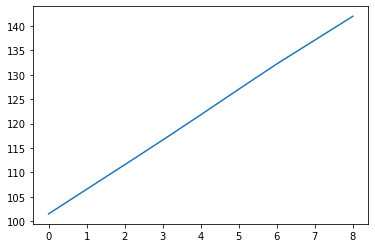

In [23]:
plt.plot(dcfs)